# Imports

In [1]:
import pandas as pd
import scanpy as sc
from loguru import logger
import gseapy as gp
import os
import inspect
import matplotlib.pyplot as plt
import json

In [2]:
config_gsea = json.load(open(r"/mnt/work/RO_src/Pipelines/STAnalysis/configs/analysis_cloud.json"))["ST"]["DEG"]["GSEA"]

In [3]:

def return_filtered_params(config, adata=None):
    # TODO: change it so that we don't need to establish the adata parameter. Automatically add it using setdefault in the if statement down below.

    params = config["params"]
    len_func_str = len(config["func_str"].split("."))
    func_str = config["func_str"]

    # TODO: try to dynamically import each module so there's no need to load all the necessary model in the utils (avoid redundant imports) with importlib
    if len_func_str == 4:
        package_name, class_eval_str, module_str, func_str = func_str.split(".")
        package_eval = eval(package_name)
        class_eval = getattr(package_eval, class_eval_str)
        module = getattr(class_eval, module_str)
        func = getattr(module, func_str)

    if len_func_str == 3:
        class_eval_str, module_str, func_str = func_str.split(".")
        class_eval = eval(class_eval_str)
        module = getattr(class_eval, module_str)
        func = getattr(module, func_str)
    if len_func_str == 2:
        class_eval_str, func_str = func_str.split(".")
        class_eval = eval(class_eval_str)
        func = getattr(class_eval, func_str)
    if len_func_str == 1:
        func = eval(func_str)

    valid_arguments = inspect.signature(func).parameters.keys()
    filtered_params = {k: v for k, v in params.items() if k in valid_arguments}

    # If Adata is None, then simply return filtered_params. Else, add the adata, data or other data type to the filtered_params dictionary
    if any(hasattr(adata, atr) for atr in ["X", "obs", "var"]):
        if "adata" in filtered_params.keys():
            filtered_params["adata"] = eval(filtered_params["adata"])
        if "data" in filtered_params.keys():
            filtered_params["data"] = eval(filtered_params["data"])
        if "rnk" in filtered_params.keys():
            filtered_params["rnk"] = eval(filtered_params["rnk"])
        if "X" in filtered_params.keys():
            filtered_params["X"] = eval(filtered_params["X"])
        return filtered_params
    else:
        return filtered_params

In [4]:

def convert_column(df, column):
    if df[column].dtype == "object":
        try:
            df[column] = df[column].astype(int)
        except ValueError:
            try:
                df[column] = df[column].astype(float)
            except ValueError:
                df[column] = df[column].astype(str)


# Read adata

In [5]:
adata = sc.read_h5ad(r"/mnt/work/RO_src/data/processed/PipelineRun_2024_06_26-08_35_14_AM/ST/Files/preprocessed_DEG_adata.h5ad")

# Perform DEG on data 

In [6]:
sc.tl.rank_genes_groups(adata, groupby="leiden_clusters",groups="all",method="wilcoxon",key_added="wilcoxon")

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [34]:
ranked_genes_list = sc.get.rank_genes_groups_df(adata, group=None, key="wilcoxon", pval_cutoff=0.05)

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


In [36]:
# Convert all genes to upper case for GSEA
ranked_genes_list["names"] = ranked_genes_list["names"].str.upper()

# Short by logfoldchange as preparation for GSEA
ranked_genes_list.sort_values(
	by=["logfoldchanges"], inplace=True, ascending=False
)

In [37]:
ranked_genes_list.to_excel("ranked_genes_list.xlsx")

# Define RSI gene sets

In [17]:
manual_sets = {
	"Negative Radiation Sensitivity (RS)": {
		"AR": {"rank": 10},
		"PRKCB": {"rank": 7},
		"RELA": {"rank": 6},
		"SUMO1": {"rank": 4},
		"PAK2": {"rank": 3},
		"IRF1": {"rank": 1},
		"HDAC1": {"rank": 2}
	},
	"Positive Radiation Sensitivity (RR)": {
		"JUN": {"rank": 9},
		"STAT1": {"rank": 8},
		"ABL1": {"rank": 5}
	}
}

# Define GARD

In [33]:

def GARD(df, rank_dictionary):
    import copy

    logger.info(f"Running GARD.")
    df_subset = df[list(rank_dictionary.keys())]
    RSI_list = []
    for index, row in df_subset.iterrows():
        RIS = 0
        temp_rank_dictionary = copy.deepcopy(rank_dictionary)
        for column, genes in row.items():
            if isinstance(
                genes, int
            ):  # If gene list is 0 and not a list of genes then put the whole set with rank as 0 (positive or negative)
                for g_name, rank in temp_rank_dictionary[column].items():
                    temp_rank_dictionary[column][g_name][
                        "rank"
                    ] = 0  # TODO: change to NA instead of integer
            if genes != 0 and column in temp_rank_dictionary:
                for dict_gene in temp_rank_dictionary[column].keys():
                    if dict_gene not in genes:
                        temp_rank_dictionary[column][dict_gene]["rank"] = 0

        RSI = (
            (
                -0.0098009
                * temp_rank_dictionary["Negative Radiation Sensitivity (RS)"]["AR"][
                    "rank"
                ]
            )
            + (
                0.0128283
                * temp_rank_dictionary["Positive Radiation Sensitivity (RR)"]["JUN"][
                    "rank"
                ]
            )
            + (
                0.0254552
                * temp_rank_dictionary["Positive Radiation Sensitivity (RR)"]["STAT1"][
                    "rank"
                ]
            )
            + (
                -0.0017589
                * temp_rank_dictionary["Negative Radiation Sensitivity (RS)"]["PRKCB"][
                    "rank"
                ]
            )
            + (
                -0.0038171
                * temp_rank_dictionary["Negative Radiation Sensitivity (RS)"]["RELA"][
                    "rank"
                ]
            )
            + (
                -0.1070213
                * temp_rank_dictionary["Positive Radiation Sensitivity (RR)"]["ABL1"][
                    "rank"
                ]
            )
            + (
                -0.0002509
                * temp_rank_dictionary["Negative Radiation Sensitivity (RS)"]["SUMO1"][
                    "rank"
                ]
            )
            + (
                -0.0092431
                * temp_rank_dictionary["Negative Radiation Sensitivity (RS)"]["PAK2"][
                    "rank"
                ]
            )
            + (
                -0.0204469
                * temp_rank_dictionary["Negative Radiation Sensitivity (RS)"]["HDAC1"][
                    "rank"
                ]
            )
            + (
                0.0441683
                * temp_rank_dictionary["Negative Radiation Sensitivity (RS)"]["IRF1"][
                    "rank"
                ]
            )
        )
        # df.at[index, "RSI"] = RSI
        RSI_list.append(RSI)

    df["RSI"] = RSI_list
    # Apply the function to each column in adata.obs
    for column in df.columns:
        convert_column(df, column)

    return df

# Calculate DEG score for each of the clusters with the GARD gene set

In [52]:
gene_set_dict = {}

In [53]:
gene_set_dict["manual_sets"] = manual_sets

In [54]:
for set_name, gene_set_list_or_dict in gene_set_dict.items():
	gene_set_names = gp.get_library_name(organism="human")
	if set_name == "manual_sets":
		gene_set_list = {}
		for gene_set_name, gene_set_dict in gene_set_list_or_dict.items():
			gene_set_list[gene_set_name] = list(gene_set_dict.keys())

In [55]:
enrichr_list = []

- Run GSEA using the gene set for each one of the clusters

In [57]:
df_list = []
groups = list(set(ranked_genes_list.group))
for group in groups:
	logger.info(
		f"Running stratified enrichr for stratified by {group = }."
	)
	# Filter the glist to have only the current group
	ranked_genes_list_per_group = ranked_genes_list[
		ranked_genes_list["group"] == group
	]

	# For each group, create a new set of enrichr parameters
	enrichr_params = {}

	# Run Enrichr
	enrichr_params = return_filtered_params(
		config=config_gsea["enrichr"], adata=ranked_genes_list_per_group
	)

	# Save key parameters to this dictionary
	enrichr_params.setdefault("gene_sets", gene_set_list)
	enrichr_params.setdefault(
		"gene_list", ranked_genes_list_per_group.names.tolist()
	)
	try:
		enr_res = gp.enrichr(**enrichr_params)
		enr_df = enr_res.results
		enr_df["set_name"] = set_name
		enr_df["group"] = group
		df_list.append(enr_df)

	except Exception as e:
		logger.error(f"No genes matched - {e}")

df = pd.concat(df_list)


2024-06-28 12:30:14.986 | INFO     | __main__:<module>:4 - Running stratified enrichr for stratified by group = '16'.
2024-06-28 12:30:14.991 | ERROR    | __main__:<module>:33 - No genes matched - No objects to concatenate
2024-06-28 12:30:14.992 | INFO     | __main__:<module>:4 - Running stratified enrichr for stratified by group = '21'.
2024-06-28 12:30:14.994 | ERROR    | __main__:<module>:33 - No genes matched - No objects to concatenate
2024-06-28 12:30:14.995 | INFO     | __main__:<module>:4 - Running stratified enrichr for stratified by group = '12'.
2024-06-28 12:30:14.998 | ERROR    | __main__:<module>:33 - No genes matched - No objects to concatenate
2024-06-28 12:30:14.998 | INFO     | __main__:<module>:4 - Running stratified enrichr for stratified by group = '23'.
2024-06-28 12:30:15.001 | ERROR    | __main__:<module>:33 - No genes matched - No objects to concatenate
2024-06-28 12:30:15.002 | INFO     | __main__:<module>:4 - Running stratified enrichr for stratified by grou

In [72]:
df.to_excel("RSI_enrichr.xlsx")

In [59]:

enrichr_list.append(df)

# Calculate GARD score

In [60]:
gsea_dataframes = {}


In [61]:

gsea_dataframes["enrichr"] = pd.concat(enrichr_list).reset_index()


In [62]:
df1 = gsea_dataframes["enrichr"][["Genes", "Term", "group"]]
df1["group"] = df1["group"].astype(str)
df1 = df1.drop_duplicates(subset='group')


/tmp/ipykernel_2664673/1099397160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["group"] = df1["group"].astype(str)


In [63]:
df1

,Genes,Term,group
0,STAT1,Positive Radiation Sensitivity (RR),0
1,PRKCB;IRF1;HDAC1,Negative Radiation Sensitivity (RS),4
3,PRKCB;IRF1,Negative Radiation Sensitivity (RS),6


In [64]:
# NOTE: check if AR can be present if we run GARD with all the data instead of the preprocessed adata (The more genes included, the better for gard)
df2 = adata.obs

In [65]:
merged_df = pd.merge(
	df2.reset_index(),
	df1,
	left_on="leiden_clusters",
	right_on="group",
	how="left",
)

In [66]:
merged_df

,index,in_tissue,array_row,array_col,n_genes_by_counts,total_counts,total_counts_Mt,pct_counts_Mt,total_counts_Ribo,pct_counts_Ribo,total_counts_Hb,pct_counts_Hb,n_genes,leiden_clusters,Genes,Term,group
0,s_008um_00301_00321-1,1,301,321,224,238.0,18.0,7.563025,0.0,0.0,0.0,0.00000,212,1,NaN,NaN,NaN
1,s_008um_00602_00290-1,1,602,290,334,360.0,18.0,5.000000,0.0,0.0,0.0,0.00000,324,6,PRKCB;IRF1,Negative Radiation Sensitivity (RS),6
2,s_008um_00425_00829-1,1,425,829,136,143.0,11.0,7.692308,0.0,0.0,0.0,0.00000,128,7,NaN,NaN,NaN
3,s_008um_00728_00006-1,1,728,6,271,291.0,6.0,2.061856,0.0,0.0,0.0,0.00000,267,5,NaN,NaN,NaN
4,s_008um_00526_00291-1,1,526,291,376,421.0,34.0,8.076009,0.0,0.0,1.0,0.23753,365,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580607,s_008um_00384_00793-1,1,384,793,181,188.0,10.0,5.319149,0.0,0.0,0.0,0.00000,177,10,NaN,NaN,NaN
580608,s_008um_00653_00166-1,1,653,166,374,414.0,26.0,6.280193,0.0,0.0,0.0,0.00000,362,9,NaN,NaN,NaN
580609,s_008um_00565_00244-1,1,565,244,316,332.0,10.0,3.012048,0.0,0.0,0.0,0.00000,310,4,PRKCB;IRF1;HDAC1,Negative Radiation Sensitivity (RS),4
580610,s_008um_00353_00477-1,1,353,477,197,210.0,12.0,5.714286,0.0,0.0,0.0,0.00000,191,5,NaN,NaN,NaN


In [67]:

# Pivot the dataframe to get the desired structure
result_df = merged_df.pivot(
	index="index", columns="Term", values="Genes"
).fillna(0)
result_df.index.name = None

# Remove a nan column that is created by the result of merging.
result_df.drop(result_df.columns[0], axis=1, inplace=True)

final_df = pd.merge(df2, result_df, left_index=True, right_index=True)
for col in final_df.select_dtypes(include=["category"]).columns:
	final_df[col] = final_df[col].cat.add_categories([0])

final_df.fillna(0, inplace=True)


/tmp/ipykernel_2664673/442647590.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)


In [73]:
final_df.to_excel("rsi_final_df.xlsx")

In [71]:
GARD_final_df = GARD(
	final_df, manual_sets
)

adata.obs = GARD_final_df
adata.obs["Negative Radiation Sensitivity (RS)"] = adata.obs[
	"Negative Radiation Sensitivity (RS)"
].astype(str)
adata.obs["Positive Radiation Sensitivity (RR)"] = adata.obs[
	"Positive Radiation Sensitivity (RR)"
].astype(str)
adata.obs["RSI"] = adata.obs["RSI"].astype(float)
adata.obs["leiden_clusters"] = adata.obs["leiden_clusters"].astype(str)

GARD_final_df.to_excel("GARD_score.xlsx")

2024-06-28 12:43:57.287 | INFO     | __main__:GARD:4 - Running GARD.


TypeError: Can't implicitly convert non-string objects to strings

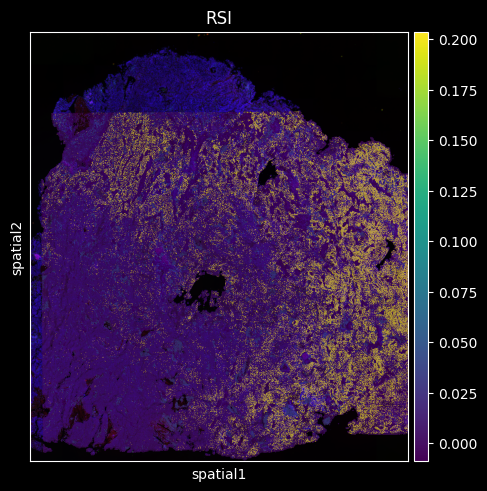

In [70]:
import squidpy as sq
sq.pl.spatial_scatter(
    adata,
    color="RSI",
    shape="square",
    size=1,
    legend_fontsize=3.5,  # adjust this value to make the legend smaller
)
plt.savefig(f"RSI_HD.png", dpi=1000)